In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, qmc
import time

In [2]:
# --- 1. Model Parameters ---
S0 = 100.0       # Initial Stock Price 
K = 100.0        # Strike Price 
r = 0.1          # Risk-free rate 
sigma = 0.1      # Volatility 
T = 1.0          # Maturity 
m_values = 2 ** np.arange(5,11)  # Time discretization steps (Example value) 

# Simulation Parameters
N_powers = np.arange(7, 14) # Powers 7 to 13
N_values = 2**N_powers      # N = 128, ..., 8192 
n_shifts = 32 # Number of random shifts for RQMC error estimation

In [3]:

def asian_call_payoff(u_samples, S0, K, r, sigma, T, m):
    """
    Computes the discounted payoff of an Asian Call Option.
    
    Args:
        u_samples: (N, m) array of Uniform(0,1) samples.
    Returns:
        (N,) array of discounted payoffs.
    """
    N = u_samples.shape[0]
    dt = T / m
    
    # 1. Inverse CDF to get Standard Normal Increments (xi)
    # Note: For very high precision in tails, one might use a custom Moro algorithm,
    # but scipy's ppf is sufficient for Step 1.
    xi = norm.ppf(u_samples) 
    
    # 2. Construct Brownian Motion Path (w)
    # w_ti = sum(xi) * sqrt(dt)
    w = np.cumsum(xi, axis=1) * np.sqrt(dt)
    
    # 3. Calculate Stock Price Path
    # S_t = S0 * exp((r - 0.5*sigma^2)t + sigma*w)
    time_grid = np.arange(1, m + 1) * dt
    S_path = S0 * np.exp((r - 0.5 * sigma**2) * time_grid + sigma * w)
    
    # 4. Asian Option Payoff
    # Average price over the path
    S_avg = np.mean(S_path, axis=1)
    
    # Max(Average - K, 0)
    payoff = np.maximum(S_avg - K, 0)
    
    # 5. Discounting
    return np.exp(-r * T) * payoff


In [4]:




# --- 2. Simulation Loop ---

print(f"{'N':<10} | {'MC Est':<12} | {'MC Err':<12} | {'RQMC Est':<12} | {'RQMC Err':<12}")
print("-" * 70)

for m in m_values:
    mc_errors = []
    rqmc_errors = []
    mc_means = []
    rqmc_means = []

    for N in N_values:
        # --- Crude Monte Carlo ---
        # Generate N random samples in m dimensions
        u_mc = np.random.rand(N, m)
        
        # Evaluate
        Y_mc = asian_call_payoff(u_mc, S0, K, r, sigma, T, m)
        
        # Estimates
        mu_mc = np.mean(Y_mc)
        # Standard Error of the mean
        err_mc = np.std(Y_mc, ddof=1) / np.sqrt(N)
        
        mc_means.append(mu_mc)
        mc_errors.append(err_mc)
        
        # --- Randomized QMC (Sobol) ---
        # We use Scipy's Sobol generator. 
        # To estimate error, we repeat the simulation 'n_shifts' times with different scrambles.
        
        shift_means = []
        
        for _ in range(n_shifts):
            # Create Sobol sampler
            sampler = qmc.Sobol(d=m, scramble=True) 
            # Generate points (must be power of 2 for Sobol balance properties)
            u_rqmc = sampler.random(n=N)
            
            # Evaluate
            Y_rqmc = asian_call_payoff(u_rqmc, S0, K, r, sigma, T, m)
            shift_means.append(np.mean(Y_rqmc))
        
        # RQMC Estimate is the mean of the shifts
        mu_rqmc = np.mean(shift_means)
        # RQMC Error is the standard deviation of the shift means (approx)
        # We use this as a proxy for the integration error.
        err_rqmc = np.std(shift_means, ddof=1)
        
        rqmc_means.append(mu_rqmc)
        rqmc_errors.append(err_rqmc)

        print(f"{N:<10} | {mu_mc:.6f}     | {err_mc:.6f}     | {mu_rqmc:.6f}     | {err_rqmc:.6f}")

N          | MC Est       | MC Err       | RQMC Est     | RQMC Err    
----------------------------------------------------------------------
128        | 5.935996     | 0.493609     | 5.411793     | 0.071206
256        | 5.652207     | 0.306218     | 5.406197     | 0.040499
512        | 5.273822     | 0.207168     | 5.410145     | 0.029204
1024       | 5.544788     | 0.160636     | 5.407676     | 0.017994
2048       | 5.417279     | 0.109734     | 5.409681     | 0.012372
4096       | 5.482367     | 0.078107     | 5.409747     | 0.007406
8192       | 5.481849     | 0.054548     | 5.411199     | 0.005139
128        | 5.290510     | 0.420056     | 5.326537     | 0.080685
256        | 4.719853     | 0.291991     | 5.328496     | 0.059221
512        | 5.591439     | 0.214036     | 5.339365     | 0.030818
1024       | 5.083297     | 0.147129     | 5.337967     | 0.016002
2048       | 5.426315     | 0.107552     | 5.331997     | 0.012164
4096       | 5.380366     | 0.076337     | 5.330980   

7 7


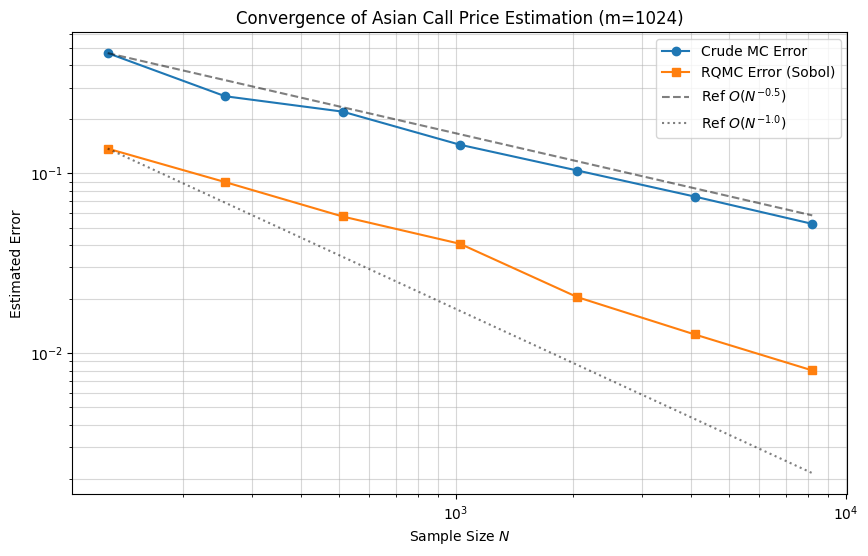

In [5]:

# --- 3. Plotting Convergence ---

plt.figure(figsize=(10, 6))
print(len(mc_errors),len(N_values))

# Plot Errors
plt.loglog(N_values, mc_errors, 'o-', label='Crude MC Error')
plt.loglog(N_values, rqmc_errors, 's-', label='RQMC Error (Sobol)')

# Reference Lines
ref_x = N_values
ref_mc = 1.0 / np.sqrt(ref_x) * mc_errors[0] * np.sqrt(N_values[0]) # Scale to match start
ref_qmc = 1.0 / ref_x * rqmc_errors[0] * N_values[0] # Scale to match start

plt.loglog(ref_x, ref_mc, 'k--', alpha=0.5, label=r'Ref $O(N^{-0.5})$')
plt.loglog(ref_x, ref_qmc, 'k:', alpha=0.5, label=r'Ref $O(N^{-1.0})$')

plt.xlabel('Sample Size $N$')
plt.ylabel('Estimated Error')
plt.title(f'Convergence of Asian Call Price Estimation (m={m})')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()


In [6]:
import numpy as np
import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt



# --- Parametri del Problema ---
S0 = 100.0
K = 100.0
r = 0.1
sigma = 0.1
T = 1.0
m = 2 ** 9  # Time discretization steps (Example value) 
Q_points = 50   # Numero di punti per la quadratura di Gauss (dispari per includere 0)


In [7]:
# --- Funzioni di Utilità ---

def get_gauss_hermite_nodes(n_points):
    """
    Restituisce nodi e pesi per l'integrazione rispetto alla densità Normale Standard.
    La funzione numpy.polynomial.hermite.hermgauss integra rispetto a e^(-x^2).
    Dobbiamo adattarla per 1/sqrt(2pi) * e^(-x^2/2).
    Change of variable: x_std = sqrt(2) * x_herm
    """
    x, w = np.polynomial.hermite.hermgauss(n_points)
    # Adattamento per la normale standard N(0,1)
    nodes = np.sqrt(2) * x
    weights = w / np.sqrt(np.pi)
    return nodes, weights


In [8]:

def generate_paths_hybrid(N, m, method, j_dir, nodes, weights):
    dt = T / m
    
    # 1. Generiamo i campioni per le m-1 dimensioni (tutte tranne j)
    # Dimensione del problema ridotto: m - 1
    if method == 'QMC':
        sampler = qmc.Sobol(d=m-1, scramble=True)
        u_samples = sampler.random_base2(m=int(np.log2(N))) # N deve essere potenza di 2 per Sobol ottimale
        z_rest = stats.norm.ppf(u_samples)
    else: # MC standard
        z_rest = np.random.normal(size=(N, m - 1))
    
    # z_rest ha shape (N, m-1). Dobbiamo inserire la dimensione j.
    # La dimensione j non è un singolo numero, ma un vettore di nodi di quadratura.
    # Per ogni campione MC (riga i), dobbiamo valutare TUTTI i nodi di quadratura k.
    
    # Costruiamo una struttura (N, Q, m) o processiamo in batch.
    # Per chiarezza, costruiamo i percorsi.
    
    # Preparare gli incrementi browniani Z
    # Z avrà shape (N, Q_points, m)
    n_nodes = len(nodes)
    Z = np.zeros((N, n_nodes, m))
    
    # Riempiamo le dimensioni != j
    # Copiamo z_rest per ogni nodo di quadratura (è fisso per un dato campione N)
    # Indici mappa: 0..j-1 vanno in 0..j-1; j..m-2 vanno in j+1..m-1
    if j_dir > 0:
        Z[:, :, :j_dir] = z_rest[:, :j_dir][:, np.newaxis, :]
    if j_dir < m - 1:
        Z[:, :, j_dir+1:] = z_rest[:, j_dir:][:, np.newaxis, :]
        
    # Riempiamo la dimensione j con i nodi di Gauss
    # Questo varia lungo l'asse 1 (nodi), ma è costante lungo l'asse 0 (campioni N)
    Z[:, :, j_dir] = nodes[np.newaxis, :] # Broadcasting
    
    # 2. Costruzione del percorso (Random Walk Standard)
    # W_ti = somma cumulativa di sqrt(dt) * Z
    W = np.cumsum(Z * np.sqrt(dt), axis=2)
    
    # 3. Calcolo Stock Prices S_ti
    # S_t = S0 * exp( (r - 0.5*sigma^2)t + sigma * W_t )
    times = np.linspace(dt, T, m)
    drift = (r - 0.5 * sigma**2) * times
    
    # Drift shape (m,), W shape (N, Q, m)
    S = S0 * np.exp(drift[np.newaxis, np.newaxis, :] + sigma * W)
    
    # 4. Media Asiatica A = (1/m) sum S_ti
    A = np.mean(S, axis=2) # Shape (N, Q)
    
    return A


In [9]:
def pricing_hybrid_with_error(N, m, method='MC', n_shifts=10):
    j_dir = 0 
    nodes, q_weights = get_gauss_hermite_nodes(Q_points)
    
    if method == 'MC':
        # Get the averaged prices across the path for each N trajectory and each Q point
        A = generate_paths_hybrid(N, m, 'MC', j_dir, nodes, q_weights)
        # Calculate payoff: (Average - K)+
        payoff_matrix = np.maximum(A - K, 0)
        # Integrate out the first dimension using Gauss weights
        v_pre = np.dot(payoff_matrix, q_weights) * np.exp(-r*T)
        
        estimate = np.mean(v_pre)
        # Error is the standard deviation of the pre-integrated values / sqrt(N)
        error = np.std(v_pre, ddof=1) / np.sqrt(N)
        return estimate, error
    
    else: # RQMC
        shift_estimates = []
        for _ in range(n_shifts):
            A = generate_paths_hybrid(N, m, 'QMC', j_dir, nodes, q_weights)
            payoff_matrix = np.maximum(A - K, 0)
            v_pre = np.dot(payoff_matrix, q_weights) * np.exp(-r*T)
            shift_estimates.append(np.mean(v_pre))
            
        estimate = np.mean(shift_estimates)
        # Error is the standard deviation between the K independent QMC shifts / sqrt(K)
        error = np.std(shift_estimates, ddof=1) / np.sqrt(n_shifts)
        return estimate, error

In [ ]:
# --- 2. Simulation Loop (Updated for proper error estimation) ---

print(f"{'N':<10} | {'MC Est':<12} | {'MC Err':<12} | {'RQMC Est':<12} | {'RQMC Err':<12}")
print("-" * 70)

for m in [32]: # Example for one discretization m
    mc_errors = []
    rqmc_errors = []
    mc_means = []
    rqmc_means = []

    for N in N_values:
        # --- Crude Monte Carlo ---
        u_mc = np.random.rand(N, m)
        Y_mc = asian_call_payoff(u_mc, S0, K, r, sigma, T, m)
        
        mu_mc = np.mean(Y_mc)
        # Proper MC Error: Standard deviation of samples / sqrt(N)
        err_mc = np.std(Y_mc, ddof=1) / np.sqrt(N) 
        
        mc_means.append(mu_mc)
        mc_errors.append(err_mc)
        
        # --- Randomized QMC (Sobol) ---
        shift_means = []
        for _ in range(n_shifts):
            sampler = qmc.Sobol(d=m, scramble=True) 
            u_rqmc = sampler.random(n=N)
            Y_rqmc = asian_call_payoff(u_rqmc, S0, K, r, sigma, T, m)
            shift_means.append(np.mean(Y_rqmc))
        
        mu_rqmc = np.mean(shift_means)
        # Proper RQMC Error: Standard deviation of the K independent shift means / sqrt(K)
        err_rqmc = np.std(shift_means, ddof=1) / np.sqrt(n_shifts) 
        
        rqmc_means.append(mu_rqmc)
        rqmc_errors.append(err_rqmc)

        print(f"{N:<10} | {mu_mc:.6f}     | {err_mc:.6f}     | {mu_rqmc:.6f}     | {err_rqmc:.6f}")

N          | MC Est       | MC Err       | RQMC Est     | RQMC Err    
----------------------------------------------------------------------
128        | 5.183669     | 0.417431     | 5.391806     | 0.013738
256        | 4.795662     | 0.288739     | 5.412130     | 0.006822
512        | 5.722166     | 0.230711     | 5.414047     | 0.004538
1024       | 5.459283     | 0.152820     | 5.409932     | 0.002799
2048       | 5.341466     | 0.104898     | 5.408296     | 0.001800
4096       | 5.384887     | 0.076022     | 5.411272     | 0.001506
8192       | 5.385133     | 0.053489     | 5.410121     | 0.001012


C:\Users\UTENTE\AppData\Local\Temp\ipykernel_41052\2420793325.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


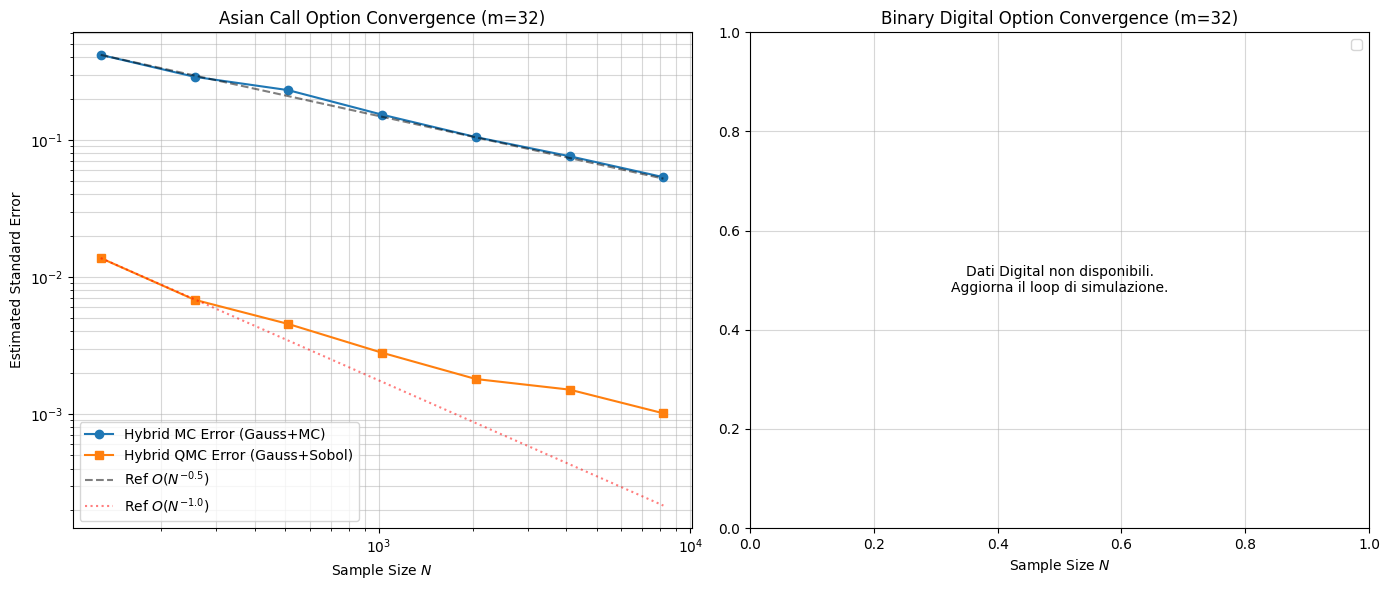

In [14]:
# --- Cella di Plotting adattata alla simulazione precedente ---
import matplotlib.pyplot as plt
import numpy as np

# Creazione del grafico con due subplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# --- 1. Plot per l'Opzione Asian Call ---
# Utilizziamo le variabili popolate nel ciclo: mc_errors e rqmc_errors
ax[0].loglog(N_values, mc_errors, 'o-', label='Hybrid MC Error (Gauss+MC)')
ax[0].loglog(N_values, rqmc_errors, 's-', label='Hybrid QMC Error (Gauss+Sobol)')

# Linee di riferimento per la Call
ref_x = N_values
# Pendenza -0.5 (Monte Carlo standard)
ref_mc_call = (mc_errors[0] * np.sqrt(N_values[0])) / np.sqrt(ref_x)
# Pendenza -1.0 (QMC con pre-integrazione)
ref_qmc_call = (rqmc_errors[0] * N_values[0]) / ref_x

ax[0].loglog(ref_x, ref_mc_call, 'k--', alpha=0.5, label=r'Ref $O(N^{-0.5})$')
ax[0].loglog(ref_x, ref_qmc_call, 'r:', alpha=0.5, label=r'Ref $O(N^{-1.0})$')

ax[0].set_title(f'Asian Call Option Convergence (m={m})')
ax[0].set_xlabel('Sample Size $N$')
ax[0].set_ylabel('Estimated Standard Error')
ax[0].grid(True, which="both", ls="-", alpha=0.5)
ax[0].legend()

# --- 2. Plot per l'Opzione Binary Digital ---
# NOTA: Se hai calcolato gli errori della digital nel loop precedente 
# (es. dig_mc_errors e dig_rqmc_errors), inseriscili qui.
# Se non li hai ancora calcolati, questa parte darà errore finché non aggiorni il loop.

try:
    ax[1].loglog(N_values, dig_mc_errors, 'o-', label='Hybrid MC Error (Digital)')
    ax[1].loglog(N_values, dig_rqmc_errors, 's-', label='Hybrid QMC Error (Digital)')
    
    ref_mc_dig = (dig_mc_errors[0] * np.sqrt(N_values[0])) / np.sqrt(ref_x)
    ref_qmc_dig = (dig_rqmc_errors[0] * N_values[0]) / ref_x
    
    ax[1].loglog(ref_x, ref_mc_dig, 'k--', alpha=0.5, label=r'Ref $O(N^{-0.5})$')
    ax[1].loglog(ref_x, ref_qmc_dig, 'r:', alpha=0.5, label=r'Ref $O(N^{-1.0})$')
except NameError:
    ax[1].text(0.5, 0.5, 'Dati Digital non disponibili.\nAggiorna il loop di simulazione.', 
               ha='center', va='center', transform=ax[1].transAxes)

ax[1].set_title(f'Binary Digital Option Convergence (m={m})')
ax[1].set_xlabel('Sample Size $N$')
ax[1].grid(True, which="both", ls="-", alpha=0.5)
ax[1].legend()

plt.tight_layout()
plt.show()